# ------------------------ Computational simulation -----------------------------

In [1]:
import numpy as np
import math
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider, Button, RadioButtons

In [2]:
# mixing factors (converted from degrees to radians)
th12 = np.radians(33.82)
th23 = np.radians(48.3)
th13 = np.radians(8.61)
delta_CP = np.radians(222)
#delta_CP = 0

# mass differences
dm21_sq = 7.39*10**(-5) # eV^2
dm31_sq = 2.523*10**(-3) # eV^2

# mass eigenstates
m1 = 0.01 # eV
m2 = np.sqrt(m1*m1 + dm21_sq) # eV
m3 = np.sqrt(m1*m1 + dm31_sq) # eV 

# total mass 
mtot = m1 + m2 + m3 #eV
assert mtot < 0.23, "Error: total mass not in agreement with experimental bounds"

# calculate third mass difference squared
dm32_sq = m3*m3 - m2*m2 # eV^2

# set energy values
E_sun_pp = 4*10**5 # eV 
E_atm = 10**11 # eV
E_acc = 10**9 #eV

# important constants:

# speed of light
c = 299792.458 # km s^-1 

# Planck constant
hbar = 6.582119569*10**(-16) # eV*s

# Astronomical unit (i.e. the distance between the Sun and the Earth)
AU = 149597870.700 # km

# Equatorial radius of the Sun
r_sun = 696342 # km
r_sun_core = 0.12*r_sun # km
# Volume sun and core
V_sun = 4*np.pi*r_sun*r_sun*r_sun / 3 # km^3
V_sun_core = 4*np.pi*r_sun_core*r_sun_core*r_sun_core / 3 # km^3
V_rest = V_sun - V_sun_core # km^3

# Electron density
N0 = 6.02214076*10**23 # Avogadro's number
mean_density_sun_core = 113*10**3 # kg m^-3
mean_mol_weight_e = 1.69 
e_density_sun_core = N0 * mean_density_sun_core / mean_mol_weight_e

# mass eigenstates vector
mar_3f = np.array([m1, m2, m3]) 

#rotational matrix
U1 = np.array([[1, 0, 0], [0, np.cos(th23), np.sin(th23)], [0, -np.sin(th23), np.cos(th23)]]) #first matrix
U2 = np.array([[np.cos(th13), 0, np.sin(th13)*np.exp(-1j*delta_CP)], [0, 1, 0], 
               [-np.sin(th13)*np.exp(1j*delta_CP), 0, np.cos(th13)]]) #second matrix
U3 = np.array([[np.cos(th12), np.sin(th12), 0], [-np.sin(th12), np.cos(th12), 0], [0, 0, 1]]) #third matrix
rot_mat_3f = np.dot(U1, np.dot(U2, U3)) #final matrix

# check that the 3x3 matrix is unitary
herm = np.transpose(np.conjugate(rot_mat_3f))

In [3]:
def full_prob(L, E, alpha):
    """Calculates the probability of a neutrino of flavour alpha to remain of that same flavour or to change into another
    flavour
    Takes as inputs the distance L (in kilometers), the energy at which the neutrino is created E (in eV), 
    and the initial flavour alpha ("electron", "muon", or "tau")
    Returns an array with three elements respectively representing the probability of the neutrino being an electron, muon
    or tau neutrino"""
    
    # transform from string to integer
    if alpha == "electron":
        a = 0
    elif alpha == "muon":
        a = 1
    elif alpha == "tau":
        a = 2
    else:
        print('Error: choose from "electron", "muon" or "tau"')
        
    # calculate X_{ij} (argument of sine squared)
    X = np.zeros((3, 3)) #store
    for i in range(3):
        for j in range(3):
            X[i, j] = 1267000000*(mar_3f[i]*mar_3f[i] - mar_3f[j]*mar_3f[j]) * L / (4*E)
        
    # calculate probabilities
    U = rot_mat_3f 
    vals = np.zeros(3) #store
    for b in range(3): 
        sum_re_parts = 0
        sum_im_parts = 0
        for i in range(3):
                for j in range(i):
                    term = np.conj(U[a, i])*U[b, i]*U[a, j]*np.conj(U[b, j])
                    re_part = np.real(term)*np.sin(X[i,j])*np.sin(X[i,j])
                    im_part = np.imag(term)*np.sin(2*X[i,j])
                    sum_re_parts += re_part
                    sum_im_parts += im_part
        if b == a:
            vals[b] = 1 - 4*sum_re_parts + 2*sum_im_parts
        else:
            vals[b] = - 4*sum_re_parts + 2*sum_im_parts
            
    return vals

In [4]:
# Interactive plot functions

def flavor(label):
    global alpha
    flavor_options = {"$ν_{e}$":"electron","$ν_{\mu}$":"muon","$ν_{τ}$":"tau"}
    alpha = flavor_options[label]
    #flavor_color = {'$ν_{e}$':'red','$ν_{\mu}$':'blue','$ν_{τ}$':'green'}
    #radio.activecolor = flavor_color[label]
    
def energyRadio(label):
    global distance 
    global energy
    energy_options = {"Sun":(E_sun_pp,0.00000035*AU),"Atmosphere":(E_atm,0.09*AU),"Accelerator":(E_acc,0.0009*AU)}
    (energy,distance) = energy_options[label]
    #distance_options = {"Sun":50,"Atmosphere":1000,"Accelerator":50}
    #distance = distance_options[label]
    
# Probability functions
def y1(x):
    p = full_prob(x, energy, alpha)[0]
    return p

def y2(x):
    p = full_prob(x, energy, alpha)[1]
    return p

def y3(x):
    p = full_prob(x, energy, alpha)[2]
    return p

#fuction to draw animation of the plot
def animate(frame):
    
    ax1.set_xlim(0, distance)
    textenergy.set_text("Neutrino Energy: \n" + "   " + str("{:.1e}".format(energy)) + "  eV")
    textdistance.set_text("Range represented: \n" + "   0 - " + str("{:.2e}".format(distance)) + "  km")
    
    xdata.append(frame)
    ydata1.append(y1(frame))
    ydata2.append(y2(frame))
    ydata3.append(y3(frame))
    
    line1.set_data(xdata,ydata1)
    line2.set_data(xdata,ydata2)
    line3.set_data(xdata,ydata3)
    
    circle1.set_alpha(y1(frame))
    circle2.set_alpha(y2(frame))
    circle3.set_alpha(y3(frame))
    
    text1.set_text(str("{0:.0f}".format(y1(frame)*100) + " %"))
    text2.set_text(str("{0:.0f}".format(y2(frame)*100) + " %"))
    text3.set_text(str("{0:.0f}".format(y3(frame)*100) + " %"))
    
    return line1, line2, line3

def run_animation():
    ani = FuncAnimation(fig, animate, frames=np.linspace(0, distance, 250),blit=False,repeat=False, interval=1)
    fig.canvas.draw()
    
#Animate event
def anim(event):
    Dslider.reset()
    xdata.clear()
    ydata1.clear()
    ydata2.clear()
    ydata3.clear()
    run_animation()
    
def update(val):
    
    d = Dslider.val
    
    blackline.set_xdata(np.linspace(d*distance,d*distance,100))
    blackline.set_ydata(np.linspace(0,1.15,100))
    
    circle1.set_alpha(y1(d*distance))
    circle2.set_alpha(y2(d*distance))
    circle3.set_alpha(y3(d*distance))
    
    text1.set_text(str("{0:.0f}".format(y1(d*distance)*100) + " %"))
    text2.set_text(str("{0:.0f}".format(y2(d*distance)*100) + " %"))
    text3.set_text(str("{0:.0f}".format(y3(d*distance)*100) + " %"))
    
    textslider.set_text(str("{:.2e}".format(d*distance)) + " km")

<IPython.core.display.Javascript object>


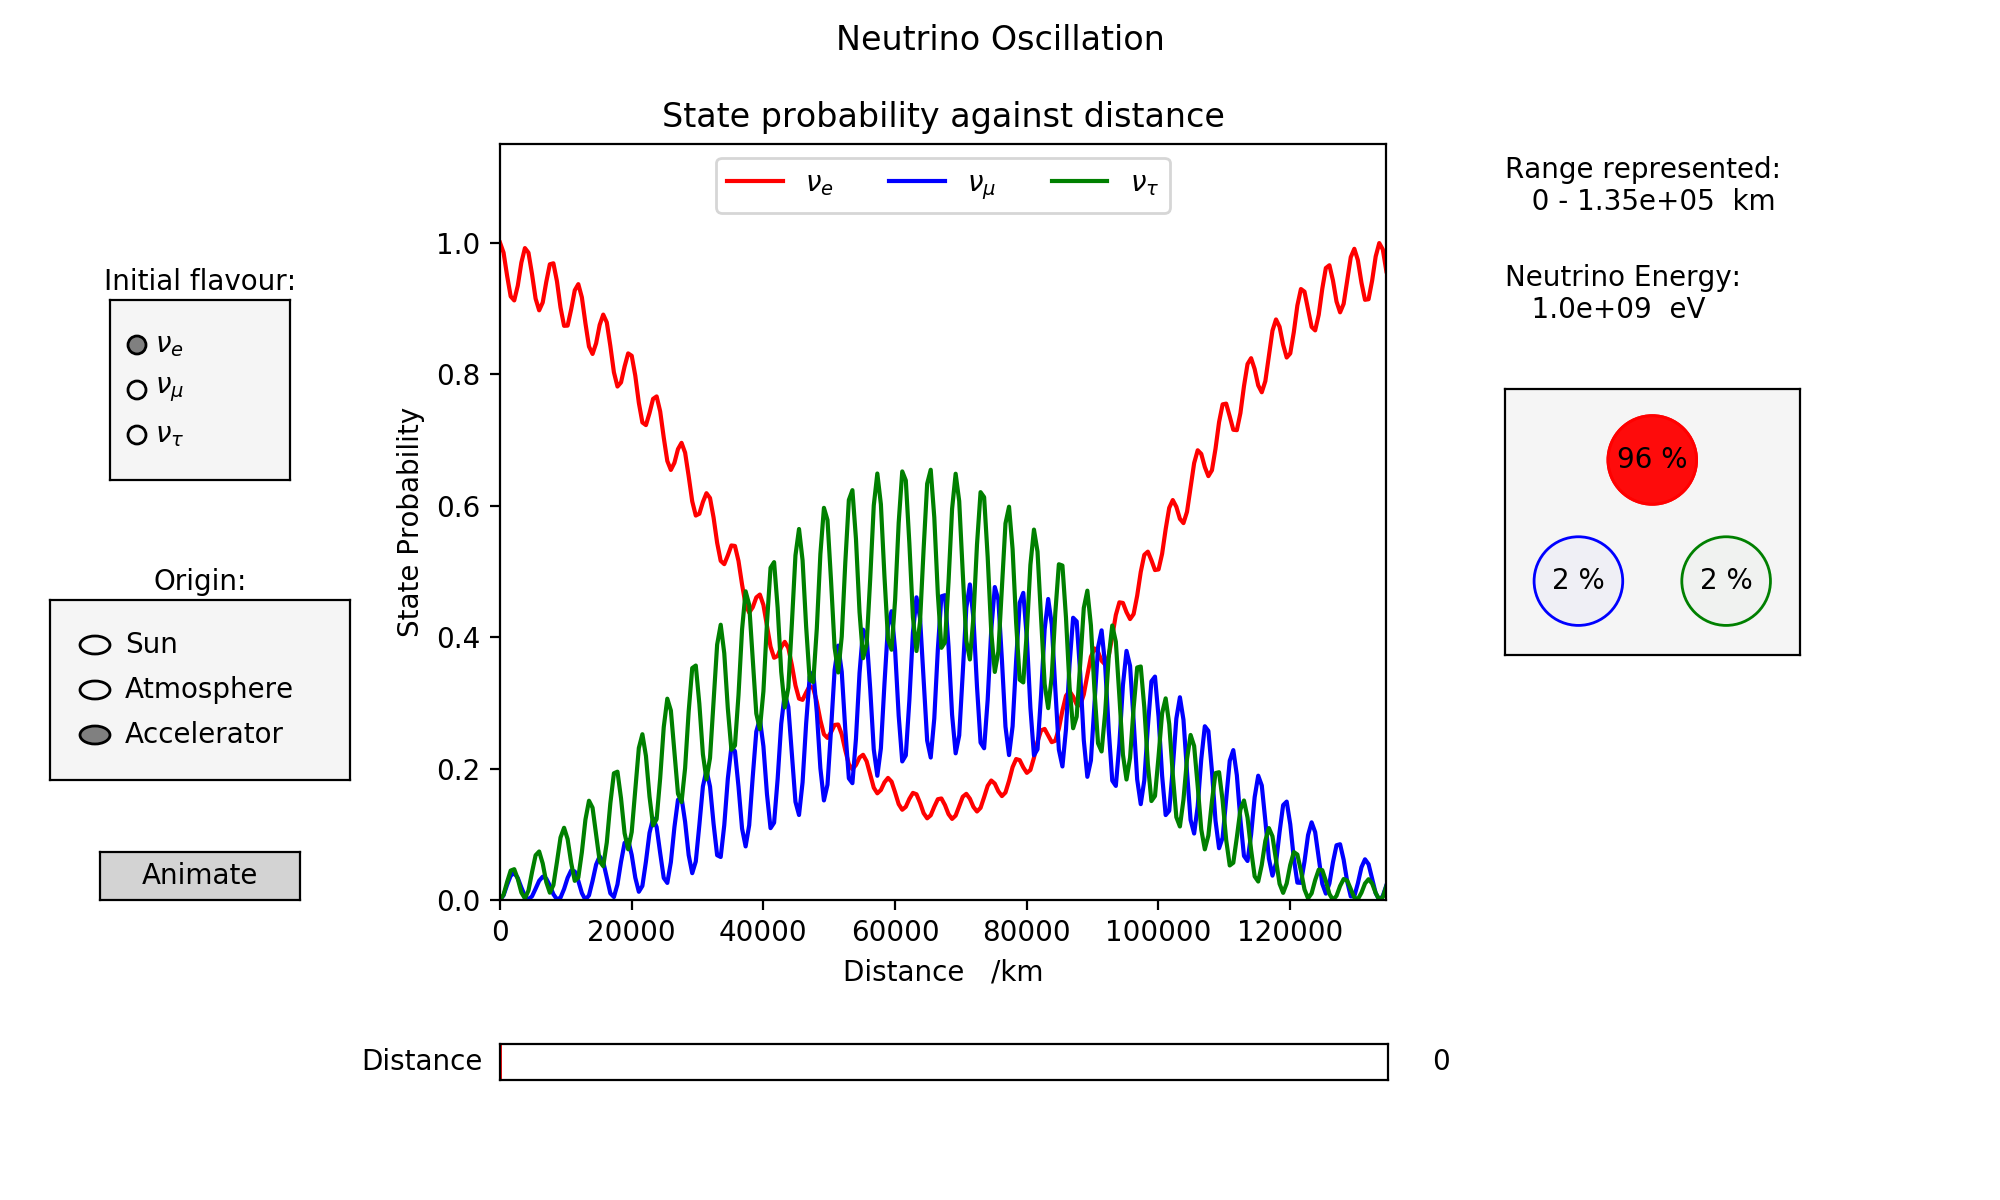

In [5]:
############# Displaying the probability plot ###############
print("\n\n\n\n\n")

#create plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6),gridspec_kw={'width_ratios': [3, 1]})
global distance 
global energy
energy = E_sun_pp
distance = 52

#flavor box
rax = plt.axes([0.05, 0.6, 0.1, 0.15],facecolor = 'whitesmoke',aspect='equal')
textflavor=plt.text(0.5, 1.1,"Initial flavour:",horizontalalignment='center', verticalalignment='center')
radio = RadioButtons(rax, ("$ν_{e}$", "$ν_{\mu}$", "$ν_{τ}$"))
(radio.circles[0]).set_facecolor('red')
(radio.circles[1]).set_facecolor('blue')
(radio.circles[2]).set_facecolor('green')
radio.activecolor='gray'

radio.on_clicked(flavor)

#energy box
rax2 = plt.axes([0.025, 0.35, 0.15, 0.15],facecolor = 'whitesmoke')
textenergy=plt.text(0.5,1.1,"Origin:",horizontalalignment='center', verticalalignment='center')
radio2 = RadioButtons(rax2, ("Sun", "Atmosphere", "Accelerator"))
for circle in radio2.circles:
    circle.set_facecolor('lightgray')
radio2.activecolor='gray'

radio2.on_clicked(energyRadio)

textenergy=plt.text(4.85,2.7,"Neutrino Energy: \n" + "   " + str("{:.1e}".format(energy)) + "  eV",horizontalalignment='left', verticalalignment='center')
textdistance=plt.text(4.85,3.3,"Range represented: \n" + "   0 - " + str("{:.2e}".format(distance)) + "  AU",horizontalalignment='left', verticalalignment='center')

#Animate button display
resetax = plt.axes([0.05, 0.25, 0.1, 0.04])
button = Button(resetax, 'Animate', color='lightgray',hovercolor="white")

button.on_clicked(anim)

#Slider
d0=0
delta_d=0.005
axslider=plt.axes([0.25, 0.1, 0.444, 0.03])
Dslider = Slider(axslider, 'Distance', 0, 1,color='gray', valinit=d0, valstep=delta_d)
Dslider.valtext.set_visible(False)
textslider=plt.text(1.05,0.5,str(0),horizontalalignment='left', verticalalignment='center')
        
Dslider.on_changed(update)

#set axis and positions
plt.subplots_adjust(left=0.25, bottom=0.25)
ax1.set_xlim(0, distance)
ax1.set_ylim(0, 1.15)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 0.9)
ax2.set_aspect('equal')
ax2.set_facecolor('whitesmoke')

#create lines, circles, and text
blackline, = ax1.plot([],[],'k--')

xdata, ydata1, ydata2, ydata3 = [], [], [], []
line1, = ax1.plot([], [], 'r-',label="$ν_{e}$")
line2, = ax1.plot([], [], 'b-',label="$ν_{\mu}$")
line3, = ax1.plot([], [], 'g-',label="$ν_{τ}$")

circle1 = plt.Circle((0.5, 0.66), radius=0.15, color='r')
circle2 = plt.Circle((0.25, 0.25), radius=0.15, color='b')
circle3 = plt.Circle((0.75, 0.25), radius=0.15, color='g')
border1 = plt.Circle((0.5, 0.66), radius=0.15, edgecolor='r',facecolor='none')
border2 = plt.Circle((0.25, 0.25), radius=0.15, edgecolor='b',facecolor='none')
border3 = plt.Circle((0.75, 0.25), radius=0.15, edgecolor='g',facecolor='none')

ax2.add_artist(circle1)
ax2.add_artist(circle2)
ax2.add_artist(circle3)
ax2.add_artist(border1)
ax2.add_artist(border2)
ax2.add_artist(border3)

text1=ax2.text(0.5, 0.66,"",horizontalalignment='center', verticalalignment='center')
text2=ax2.text(0.25, 0.25,"",horizontalalignment='center', verticalalignment='center')
text3=ax2.text(0.75, 0.25,"",horizontalalignment='center', verticalalignment='center')

fig.suptitle('Neutrino Oscillation')
ax1.set_title("State probability against distance")
ax1.set_xlabel("Distance   /km")
ax1.set_ylabel("State Probability")
ax1.legend(ncol = 3,loc = 9)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
plt.show();

print("\n\n\n\n\n")